In [1]:
import numpy as np
from scipy.fft import fft, fftfreq, fftshift
from scipy import signal
import scipy
import matplotlib.pyplot as plt
import os
from natsort import natsorted
from pprint import pprint
import pandas as pd


In [2]:
os.getcwd()

'/home/biolab/eeg-analysis/EEG_data'

In [3]:
labels = ['COUNTER INTERPOLATED', 'AF3', 'T7', 'Pz', 'T8', 'AF4', 'RAW_CQ', 'GYROX', 'GYROY', 'MARKER', 'MARKER_HARDWARE', 'SYNC', 'TIME_STAMP_s', 'TIME_STAMP_ms', 'CQ_AF3', 'CQ_T7', 'CQ_Pz', 'CQ_T8', 'CQ_AF4']
filename_csv = '../data/Recordings.csv'
eegdata_df = pd.read_csv(filename_csv, header=None, skiprows=[0], names=labels) 
eegdata_df.head()

,COUNTER INTERPOLATED,AF3,T7,Pz,T8,AF4,RAW_CQ,GYROX,GYROY,MARKER,MARKER_HARDWARE,SYNC,TIME_STAMP_s,TIME_STAMP_ms,CQ_AF3,CQ_T7,CQ_Pz,CQ_T8,CQ_AF4
1.0,0.0,4398.974121,4645.641113,4399.487305,4553.846191,4288.205078,500.0,0.0,0.0,0.0,0.0,0.0,1391.0,571.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,4360.512695,4515.897461,4293.333008,4384.615234,4320.512695,16249.0,6167.0,9567.0,0.0,0.0,0.0,1391.0,580.0,3.0,0.0,0.0,0.0,0.0
3.0,0.0,4362.051270,4406.153809,4240.000000,4253.333008,4392.307617,500.0,0.0,0.0,0.0,0.0,0.0,1391.0,588.0,3.0,0.0,0.0,0.0,0.0
4.0,0.0,4335.384277,4443.589844,4231.794922,4261.025391,4399.487305,0.0,6165.0,9564.0,0.0,0.0,0.0,1391.0,597.0,3.0,0.0,0.0,0.0,0.0
5.0,0.0,4372.307617,4644.615234,4310.256348,4318.461426,4398.974121,500.0,0.0,0.0,0.0,0.0,0.0,1391.0,605.0,3.0,0.0,0.0,0.0,0.0


## Preprocessing
- filtering
4-64Hz bandpassfilter
- rereferencing
use average

In [4]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    # to gain butterworth bandpass filter paramater
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def apply_filter_to_signal(sig, lowcut, highcut, fs, order=4):
    # apply butterworth bandpass filter to the signal
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    filtered = signal.filtfilt(b, a, sig)
    return filtered

def fft_for_signal(sig, fs):
    # apply fft for signal
    shifted_ffted_sig = fftshift(fft(sig))
    shifted_freq = fftshift(fftfreq(sig.shape[-1], 1/fs))
    return shifted_ffted_sig, shifted_freq

def plot_signal_fft(sig, fs):
    # plot signal and freq spectrum in a figure
    ffted_sig, shifted_freq = fft_for_signal(sig, fs)
    
    plt.subplot(2,1,1)
    plt.plot(sig)
    plt.subplot(2,1,2) 
    plt.plot(shifted_freq[int(len(sig)//2):-1], 
        np.abs(ffted_signal[int(len(sig)//2):-1]))
    plt.xlim([0, 5])
    # plt.ylim([0, 40000])
    plt.autoscale(tight=True)
    plt.show()

def plot_fft(sig, fs):
    # plot freq spect that filter applied signal 
    N = len(sig)
    T = 1.0 / fs
    sig = sig * scipy.signal.blackman(N)
    ffted_sig, shifted_freq = fft_for_signal(sig, fs)
    plt.plot(shifted_freq, 1.0/N * np.abs(ffted_sig))
    plt.xlim(0, )
    plt.grid()
    plt.show()

In [5]:
signal_array = eegdata_df[['AF3', 'T7', 'Pz', 'T8', 'AF4']].values.T

Filter and Rereference

In [6]:
for i in range(len(signal_array)):
    signal_array[i] = apply_filter_to_signal(signal_array[i], 4, 30, 128)

for i in range(signal_array.shape[1]):
    signal_array[:,i] = signal_array[:,i] - np.mean(signal_array[:,i])

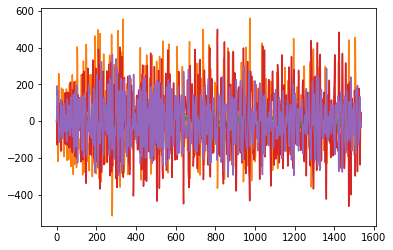

In [7]:
plt.plot(signal_array.T)

## extract alpha and beta

In [8]:
alpha = []
for i in range(len(signal_array)):
    alpha.append(apply_filter_to_signal(signal_array[i], 8, 13, 128))

alpha_array = np.array(alpha)

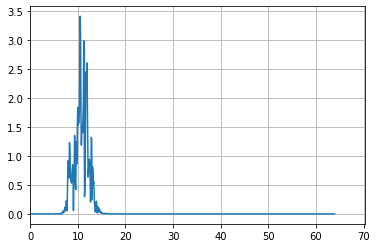

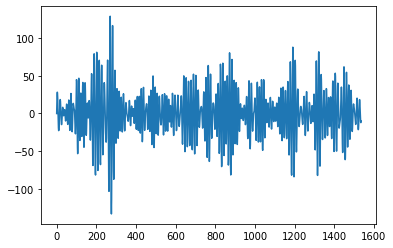

In [9]:
plot_fft(alpha_array[0], 128)
plt.show()
plt.plot(alpha_array[0])
plt.show()

In [10]:
beta = []
for i in range(len(signal_array)):
    beta.append(apply_filter_to_signal(signal_array[i], 13, 30, 128))

beta_array = np.array(beta)

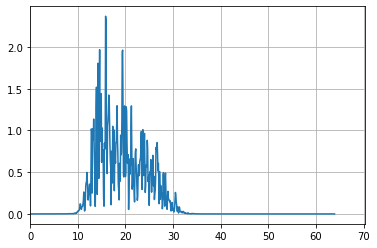

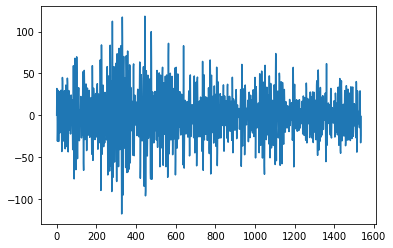

In [80]:
plot_fft(beta_array[0], 128)
plt.show()
plt.plot(beta_array[0])
plt.show()

Powerspectrum
直流成分はそのまま，それ以外の成分は2倍して積分

In [100]:
def calculate_powerspectrum(original_signal, fs=128, datalen=1, start=0, period=120, bottom_freq=8, upper_freq=13):
    '''
    original_signal: ndarray, 
    fs: int, sampling frequency
    datalen: int, length of window
    start: int, begin time of calcurate powerspectrum
    period: int, end time of calcurate powerspectrum
    bottom_freq: int, bottom of band of the spectrum
    upper_freq: int, upper of band of the spectrum
    '''
    window = signal.windows.hann(datalen*fs)
    powerspectrum_list = []
    period = min(period, len(original_signal)//fs)
    for i in range((period-start) // (datalen)):
        # cutout signal by window
        data = original_signal[fs*i:fs*(i+datalen)]
        # fft-ed signal       
        fft_data = fft(data*window)
        power_fftdata = abs(fft_data) ** 2 / len(fft_data)
        single_pow = [power_fftdata[0] + 2*power_fftdata[1:len(fft_data//2)]]
        # print(len(single_pow[0]))
        powerspectrum_list.append(sum(single_pow[0][len(fft_data)//2+bottom_freq//2:len(fft_data)//2+upper_freq//2]))

    return powerspectrum_list

In [101]:
tmp = calculate_powerspectrum(signal_array[0])

In [102]:
tmp

[0.31010410314494036,
 0.1497123763151203,
 0.038796538585949523,
 1.2064342529887337,
 0.20176014941980047,
 0.04925370243889654,
 0.6386340966663743,
 0.060181045352829435,
 0.1549906135826103,
 0.22045305238592178,
 0.6047233370328203,
 0.2302583964165661]

In [55]:
N = len(eegdata_df['AF3'])
T = 1.0 / 128
sig = eegdata_df['AF3'] - eegdata_df['AF3'].mean()
sig_f = fft(sig)
xf = fftfreq(N, T)
xf = fftshift(xf)
yplot = fftshift(sig_f)
plt.plot(xf, 1.0/N * np.abs(yplot))
plt.xlim(0, 64)
plt.grid()
plt.show()
# power_fftdata = abs(fft_data) ** 2 / len(fft_data)

AttributeError: 'Series' object has no attribute 'flags'

In [ ]:
original_signal = eegdata_df['AF3'] - eegdata_df['AF3'].mean()
data = original_signal
fft_d = fft(data)
fft_data = fftshift(fft_d)
fftf = fftfreq(N, T)
fftf = fftshift(fftf)
power_fftdata = abs(fft_data) ** 2 / len(fft_data)

In [56]:
eegdata_df['mean'] = eegdata_df[['AF3', 'T7', 'Pz', 'T8', 'AF4']].mean(axis=1)

In [57]:
rereference = lambda x: x - eegdata_df['mean']
rereferencedeeg_df = eegdata_df[['AF3', 'T7', 'Pz', 'T8', 'AF4']].apply(rereference)

In [59]:
rereferencedeeg_df.shape

(1536, 5)

In [60]:
eegdata_df.shape

(1536, 20)

In [70]:
plt.plot(rereferencedeeg_df['Pz'][])

SyntaxError: invalid syntax (<ipython-input-70-dca0750de24b>, line 1)

In [ ]:
rereferencedeeg_df['Pz'].shape